In [11]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
from scipy import stats
from scipy import signal
from itertools import *
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario


In [12]:
dataset_sujetos_str = []
for i in range(1,10):
    dataset_sujetos_str.append('P0'+str(i))
    dataset_sujetos_str.append('S0'+str(i))
dataset_sujetos_str.append('P10')
dataset_sujetos_str.append('S10')


In [13]:
def electrodos_importantes(dataset):
    electrodo8 = dataset[:, 7, :]
    electrodo44 = dataset[:, 43, :]
    electrodo80 = dataset[:, 79, :]
    electrodo131 = dataset[:, 130, :]
    electrodo185 = dataset[:, 184, :]

    return [electrodo8, electrodo44, electrodo80, electrodo131, electrodo185]


In [14]:
def epoch_count(dataset):
    return dataset.shape[0]

def electrodes_count(dataset):
    return dataset.shape[2]

def averageTimeSeries(tsList):
    for i in range(len(tsList[0])):
        yield np.mean(map(lambda ts: ts[i], tsList))

def averageInEpoch(epoch_idx, dataset):
    return averageTimeSeries(map(lambda electrodo: electrodo[epoch_idx], electrodos_importantes(dataset)))


In [15]:
def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 45.0, zip(freqs, pots))
    freqs_relevantes = map(lambda x: x[0], pairs_relevantes)
    amplitudes_relevantes = map(lambda x: x[1], pairs_relevantes)
    return (freqs_relevantes, amplitudes_relevantes)
    

In [16]:
def graph_fft(dataset):
    epoch_count(dataset)
    averagedElectrodesByEpoch = [list(averageInEpoch(i,dataset)) for i in range(epoch_count(dataset))] 
    allEpochs = pd.DataFrame();
    for i in range(epoch_count(dataset)):
        epoch_welch = scipy.signal.welch(averagedElectrodesByEpoch[i], fs=250)
        frecuencas_sampleadas = epoch_welch[0]; # Deberia ser siempre lo mismo
        (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(frecuencas_sampleadas, epoch_welch[1])
        allEpochs = allEpochs.append(pd.DataFrame(pots_relevantes).transpose());

    allEpochs = allEpochs.reset_index();
    sns.heatmap(allEpochs.transpose(), cmap="viridis", vmax=2e-11 )
    del allEpochs
    plt.show()

    

In [22]:
def get_epoch(epoch_idx,electrodo_idx, dataset):
    return dataset[epoch_idx, electrodo_idx, :]

def par_frecuencias_potencias_epoch(epoch_idx,electrodo_idx,dataset):
    welch_result = scipy.signal.welch(get_epoch(epoch_idx,electrodo_idx,dataset), fs=250)
    return freq_pots_relevantes(welch_result[0], welch_result[1])

# Dado un dataset y un electrodo devuelve una lista de potencias promedio para cada epoch
def potencias_promedio(electrodo_idx,dataset):
    potencias = [par_frecuencias_potencias_epoch(i,electrodo_idx, dataset)[1] for i in range(epoch_count(dataset))]
    res = []
    for i in range(len(potencias[0])):
        res.append(np.average([potencias[j][i] for j in range(len(potencias))]))
    del potencias
    return res

def graph_potencias(dataset):
    colors = sns.color_palette("muted", n_colors=electrodes_count(dataset))
    for i in range(electrodes_count(dataset)):
        sns.tsplot(potencias_promedio(i, dataset), color=colors[i])
    plt.show()

In [23]:
datasetPrincipal = scipy.io.loadmat('datos/S01.mat')['data']


/home/brian/Documents/facultad/cienciadatos/venv/local/lib/python2.7/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


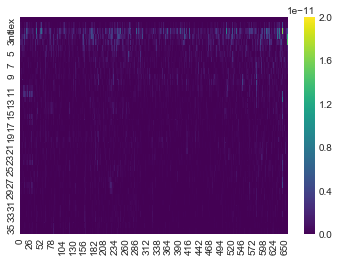

In [19]:
graph_fft(datasetPrincipal)

/home/brian/Documents/facultad/cienciadatos/venv/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


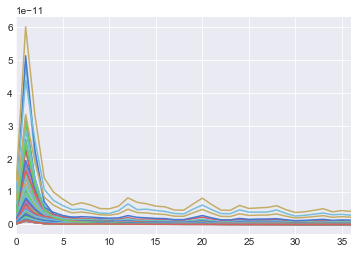

In [24]:
graph_potencias(datasetPrincipal)

In [25]:
del datasetPrincipal

In [26]:
def potencia_banda(low, high, potencias_promedio, frecuencias):
    # Thomas dice np.average
    return np.average(map(lambda x: x[0], ifilter(lambda x: x[1] >= low and x[1] < high, izip(potencias_promedio, frecuencias))))

def get_bandas_dict(dataset):
    potencias_promedio_by_electrode = []
    for i in range(electrodes_count(dataset)):
        potencias_promedio_by_electrode.append(potencias_promedio(i, dataset))
    potencias_promedio_total = [np.average([potencias_promedio_by_electrode[j][i] for j in range(len(potencias_promedio_by_electrode))]) for i in range(len(potencias_promedio_by_electrode[0]))]
    del potencias_promedio_by_electrode
    frecuencias = par_frecuencias_potencias_epoch(0,0, dataset)[0]
    res = {}
    res['delta'] = potencia_banda(0., 4.0, potencias_promedio_total, frecuencias)
    res['theta'] = potencia_banda(4.0, 8.0, potencias_promedio_total, frecuencias)
    res['alpha'] = potencia_banda(8.0, 13.0, potencias_promedio_total, frecuencias)
    res['beta'] = potencia_banda(13.0, 30., potencias_promedio_total, frecuencias)
    res['gamma'] = potencia_banda(30.0, 125., potencias_promedio_total, frecuencias)
    
    return res

In [31]:
bandas_frame_columns = ['delta','theta','alpha','beta','gamma','tipo']
bandas_frame = pd.DataFrame(data=[], columns=bandas_frame_columns)

for sujeto_str in dataset_sujetos_str[0:6]:
    dataset = scipy.io.loadmat('datos/{0}.mat'.format(sujeto_str))['data']
    bandas_dict = get_bandas_dict(dataset)
    if sujeto_str[0] == 'P':
        bandas_dict['tipo'] = 'normal'
    else:
        bandas_dict['tipo'] = 'disminuido'
    bandas_sujeto = pd.DataFrame(data=[bandas_dict], columns=bandas_frame_columns)
    bandas_frame = bandas_frame.append(bandas_sujeto)

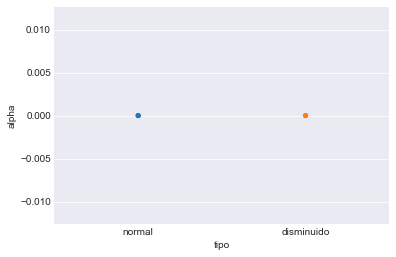

In [33]:
sns.stripplot(data=bandas_frame, y="alpha", x="tipo")
plt.show()


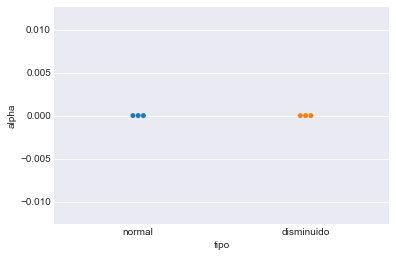

In [34]:
sns.swarmplot(x="tipo", y="alpha", data=bandas_frame)
plt.show()